<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館

In [1]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

     |████████████████████████████████| 98 kB 4.1 MB/s 
     |████████████████████████████████| 96 kB 3.2 MB/s 
     |████████████████████████████████| 4.1 MB 9.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [20]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({'１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九'}))

def add_pref_district(df_data, district, is_master=False):
    df_data['都道府県'] = '東京都'
    df_data['市区町村'] = district
    if is_master:
        df_data['町丁目'] = df_data['町丁目'].apply(number_to_kanji)
        df_data['町名'] = df_data['町丁目'].str.replace('[一二三四五六七八九十]丁目', '', regex=True)

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [7]:
library_columns = ['施設分類', '施設名', '都道府県', '市区町村', '所在地', '緯度', '経度']

## 港区

In [11]:
minato_library_url = 'https://opendata.city.minato.tokyo.jp/dataset/52105970-c407-423c-8827-2cfc229bf864/resource/dc824430-1645-45f6-8dc1-229b2d2c97a2/download/minatokushisetsujoho_tosyokan.csv'
df_minato_library = get_data_csv_url(minato_library_url)
add_pref_district(df_minato_library, '港区')
df_minato_library = df_minato_library[df_minato_library['第2分類'] == '図書館'].reset_index(drop=False)
df_minato_library = df_minato_library.rename(columns={'第2分類':'施設分類', 'ページタイトル':'施設名'})[library_columns]
print(df_minato_library.shape)

(7, 7)


In [12]:
df_minato_library

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,みなと図書館,東京都,港区,港区芝公園三丁目2番25号,35.660020,139.750171
1,図書館,三田図書館,東京都,港区,港区芝五丁目36番4号 札の辻スクエア4階～6階,35.647149,139.745214
2,図書館,麻布図書館,東京都,港区,港区六本木五丁目12番24号,35.657508,139.735818
3,図書館,赤坂図書館,東京都,港区,港区南青山一丁目3番3号 青山一丁目タワー3階,35.671596,139.725328
4,図書館,高輪図書館,東京都,港区,港区高輪一丁目16番25号 高輪コミュニティーぷらざ3階,35.642079,139.734035
5,図書館,港南図書館,東京都,港区,港区港南三丁目3番17号 シティハイツ港南1階,35.633141,139.749575
6,図書館,高輪図書館分室,東京都,港区,港区高輪一丁目4番35号 高輪子ども中高生プラザ3階,35.642412,139.734855


## 墨田区

In [13]:
sumida_library_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/library.csv'
df_sumida_library = get_data_csv_url(sumida_library_url, 'shift-jis')
add_pref_district(df_sumida_library, '墨田区')
df_sumida_library['施設分類'] = '図書館'
df_sumida_library = df_sumida_library.rename(columns={'施設名称':'施設名'})[library_columns]
print(df_sumida_library.shape)

(7, 7)


In [14]:
df_sumida_library

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,ひきふね図書館,東京都,墨田区,墨田区京島一丁目36番5号,35.717058,139.819491
1,図書館,緑図書館,東京都,墨田区,墨田区緑二丁目24番5号,35.695740,139.800613
2,図書館,立花図書館,東京都,墨田区,墨田区立花六丁目8番1号101号室,35.710694,139.834842
3,図書館,八広図書館,東京都,墨田区,墨田区八広五丁目10番1号104号室,35.724810,139.825793
4,図書館,東駒形コミュニティ会館図書室,東京都,墨田区,墨田区東駒形四丁目14番1号,35.705517,139.807746
5,図書館,梅若橋コミュニティ会館図書室,東京都,墨田区,墨田区堤通二丁目9番1号,35.735335,139.816746
6,図書館,横川コミュニティ会館図書室,東京都,墨田区,墨田区横川五丁目9番1号,35.705116,139.817580


## 練馬区

In [15]:
nerima_library_url = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/toshokan.files/toshokan.csv'
df_nerima_library = get_data_csv_url(nerima_library_url, 'shift-jis')
add_pref_district(df_nerima_library, '練馬区')
df_nerima_library = df_nerima_library[~df_nerima_library['名称'].str.contains('受取窓口')].reset_index(drop=True)
df_nerima_library['施設分類'] = '図書館'
df_nerima_library = df_nerima_library.rename(columns={'名称':'施設名'})[library_columns]
print(df_nerima_library.shape)

(13, 7)


In [16]:
df_nerima_library.head()

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,小竹図書館,東京都,練馬区,練馬区小竹町2-43-1,35.741905,139.675992
1,図書館,練馬図書館,東京都,練馬区,練馬区豊玉北6-8-1,35.734021,139.652060
2,図書館,貫井図書館,東京都,練馬区,練馬区貫井1-36-16,35.737000,139.635924
3,図書館,平和台図書館,東京都,練馬区,練馬区平和台1-36-17,35.760001,139.664822
4,図書館,春日町図書館,東京都,練馬区,練馬区春日町5-31-2-201,35.751298,139.639314


### 台東区

In [76]:
taito_library_url = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_12.csv'
df_taito_library = get_data_csv_url(taito_library_url, 'shift-jis')
add_pref_district(df_taito_library, '台東区')
df_taito_library['施設分類'] = '図書館'
df_taito_library = df_taito_library.rename(columns={'名称':'施設名', 'X座標':'経度', 'Y座標':'緯度'})[library_columns]
print(df_taito_library.shape)

(8, 7)


In [77]:
df_taito_library

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,すこやかとしょしつ,東京都,台東区,東上野4丁目22番8号（台東保健所3階）,35.714604,139.781534
1,図書館,くらまえオレンジ図書館,東京都,台東区,蔵前4丁目14番6号(環境ふれあい館ひまわり6階),35.703815,139.789655
2,図書館,石浜図書館,東京都,台東区,橋場1丁目35番16号,35.725365,139.807733
3,図書館,根岸図書館,東京都,台東区,根岸5丁目18番13号,35.729163,139.790533
4,図書館,中央図書館浅草橋分室,東京都,台東区,浅草橋2丁目8番7号,35.699456,139.783475
5,図書館,中央図書館,東京都,台東区,西浅草3丁目25番16号,35.717234,139.789904
6,図書館,台東区立中央図書館 谷中分室,東京都,台東区,谷中5丁目6番5号 台東区谷中防災コミュニティセンター 3F,35.725625,139.766758
7,図書館,池波正太郎記念文庫,東京都,台東区,西浅草3丁目25番16号,35.717218,139.789840


## 図書館マスター

In [78]:
df_library_master = pd.concat([
    df_minato_library,
    df_sumida_library,
    df_nerima_library,
    df_taito_library,
]).reset_index(drop=True)
print(df_library_master.shape)

(35, 7)


In [79]:
df_library_master.head()

,施設分類,施設名,都道府県,市区町村,所在地,緯度,経度
0,図書館,みなと図書館,東京都,港区,港区芝公園三丁目2番25号,35.660020,139.750171
1,図書館,三田図書館,東京都,港区,港区芝五丁目36番4号 札の辻スクエア4階～6階,35.647149,139.745214
2,図書館,麻布図書館,東京都,港区,港区六本木五丁目12番24号,35.657508,139.735818
3,図書館,赤坂図書館,東京都,港区,港区南青山一丁目3番3号 青山一丁目タワー3階,35.671596,139.725328
4,図書館,高輪図書館,東京都,港区,港区高輪一丁目16番25号 高輪コミュニティーぷらざ3階,35.642079,139.734035


## 人口マスタ

In [80]:
population_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population_master.shape)
population_master.head()

(527, 10)


,町丁目,世帯数,人口男,人口女,人口合計,都道府県,市区町村,町名,緯度,経度
0,三田一丁目,2251.0,1809.0,2166.0,3975.0,東京都,港区,三田,35.653750,139.741676
1,三田三丁目,1086.0,798.0,878.0,1676.0,東京都,港区,三田,35.643955,139.743205
2,三田二丁目,2404.0,2022.0,2481.0,4503.0,東京都,港区,三田,35.649845,139.741681
3,三田五丁目,3617.0,2930.0,3629.0,6559.0,東京都,港区,三田,35.646272,139.738259
4,三田四丁目,2017.0,1606.0,1959.0,3565.0,東京都,港区,三田,35.643942,139.739434


In [81]:
df_tokyo_district_master = population_master[['市区町村', '町名', '町丁目', '緯度', '経度']].copy()

In [82]:
%%time
# 一番近い施設の距離
df_tokyo_district_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'min')
# 近い3件の距離の平均
df_tokyo_district_master['図書館(平均距離)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'mean', 3)
# 2km以内の施設の数
df_tokyo_district_master['図書館(数)'] = get_value_of_nearest_facility(df_tokyo_district_master, df_library_master, '図書館', 'count', 2)

CPU times: user 2.71 s, sys: 28.2 ms, total: 2.73 s
Wall time: 2.72 s


In [83]:
print(df_tokyo_district_master.shape)
df_tokyo_district_master.head()

(527, 8)


,市区町村,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,港区,三田,三田一丁目,35.653750,139.741676,0.674325,0.837270,5
1,港区,三田,三田三丁目,35.643955,139.743205,0.398823,0.675712,6
2,港区,三田,三田二丁目,35.649845,139.741681,0.437871,0.824182,6
3,港区,三田,三田五丁目,35.646272,139.738259,0.528087,0.588880,6
4,港区,三田,三田四丁目,35.643942,139.739434,0.447382,0.536608,5


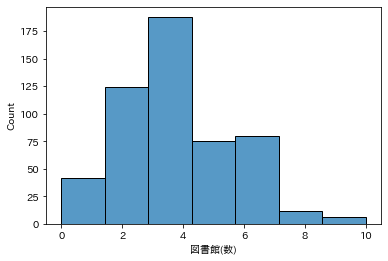

In [84]:
sns.histplot(df_tokyo_district_master['図書館(数)'], bins=7)
plt.show()

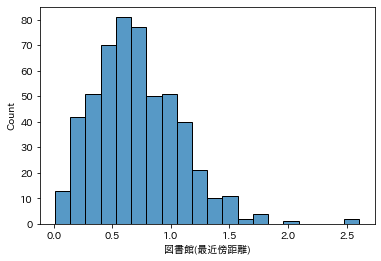

In [85]:
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)'], bins=20)
plt.show()

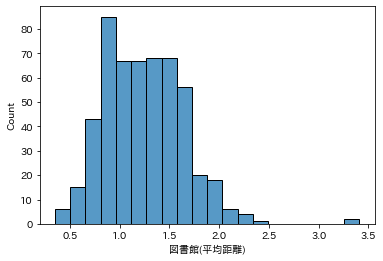

In [86]:
sns.histplot(df_tokyo_district_master['図書館(平均距離)'], bins=20)
plt.show()

In [87]:
def normalize_score(sr_data, high=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    high = score.quantile(0.99)
    low = score.quantile(0.01)
    score[score > high] = high
    score[score < low] = low
    
    return (score - low)/(high - low)

def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

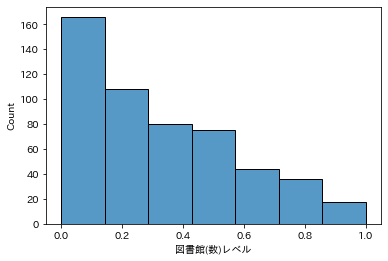

In [88]:
df_tokyo_district_master['図書館(数)レベル'] = normalize_score(df_tokyo_district_master['図書館(数)'])
sns.histplot(df_tokyo_district_master['図書館(数)レベル'], bins=7)
plt.show()

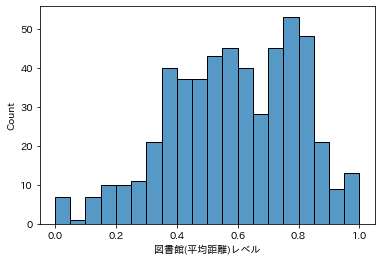

In [89]:
df_tokyo_district_master['図書館(平均距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(平均距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(平均距離)レベル'], bins=20)
plt.show()

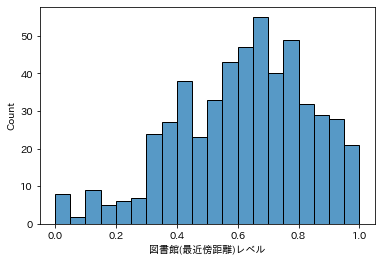

In [90]:
df_tokyo_district_master['図書館(最近傍距離)レベル'] = normalize_score(df_tokyo_district_master['図書館(最近傍距離)'], False)
sns.histplot(df_tokyo_district_master['図書館(最近傍距離)レベル'], bins=20)
plt.show()

In [91]:
score_list = [
    df_tokyo_district_master['図書館(最近傍距離)レベル'] * 1.0,
    df_tokyo_district_master['図書館(平均距離)レベル'] * 0.7,
    df_tokyo_district_master['図書館(数)レベル'] * 0.5,
]
df_tokyo_district_master['_図書館スコア'] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False))
df_tokyo_district_master['図書館スコア'] = rank_score(df_tokyo_district_master['_図書館スコア'])

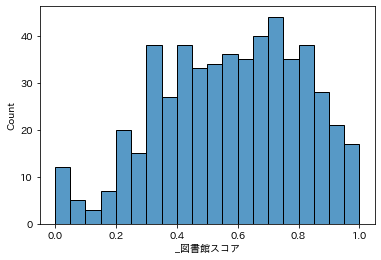

In [92]:
sns.histplot(df_tokyo_district_master['_図書館スコア'], bins=20)
plt.show()

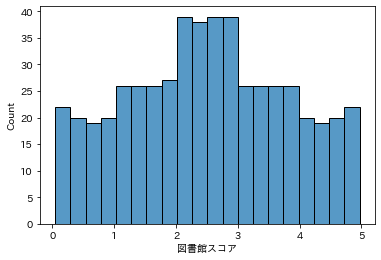

In [93]:
sns.histplot(df_tokyo_district_master['図書館スコア'], bins=20)
plt.show()

In [94]:
df_tokyo_district_master[['市区町村', '町丁目', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)', '図書館スコア']].to_csv(os.path.join(DIR_NAME, 'library.csv'), index=False)

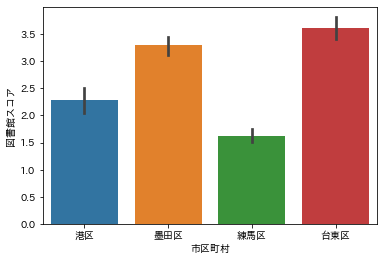

In [99]:
sns.barplot(x='市区町村', y='図書館スコア', data=df_tokyo_district_master)
plt.show()

In [95]:
df_library_level = df_tokyo_district_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')['図書館スコア'].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values('図書館スコア', ascending=False)[
    ['市区町村', '町名', '町丁目', '図書館スコア', '_図書館スコア', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']
].reset_index(drop=True)
print(df_library_level.shape)

(130, 8)


In [97]:
df_library_level.head(20)

,市区町村,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,台東区,蔵前,蔵前四丁目,4.968314,1.000000,0.088240,0.719408,7
1,台東区,松が谷,松が谷四丁目,4.968314,1.000000,0.181948,0.353930,6
2,台東区,西浅草,西浅草三丁目,4.968314,1.000000,0.191854,0.427795,8
3,台東区,千束,千束一丁目,4.968314,1.000000,0.212950,0.479959,6
4,台東区,上野,上野七丁目,4.923954,0.996995,0.207757,0.683835,7
5,墨田区,京島,京島一丁目,4.885932,0.979192,0.017763,0.793960,6
6,墨田区,東駒形,東駒形四丁目,4.873257,0.958334,0.205009,0.862157,7
7,台東区,橋場,橋場一丁目,4.847909,0.956018,0.128811,0.992986,7
8,台東区,浅草橋,浅草橋五丁目,4.835234,0.955555,0.138271,0.813812,6
9,港区,高輪,高輪一丁目,4.822560,0.955492,0.215805,0.525269,5


In [98]:
df_library_level.tail(20)

,市区町村,町名,町丁目,図書館スコア,_図書館スコア,図書館(最近傍距離),図書館(平均距離),図書館(数)
110,台東区,秋葉原,秋葉原,2.024715,0.487318,0.865837,1.272363,3
111,練馬区,氷川台,氷川台二丁目,2.018378,0.487306,0.515224,1.660138,2
112,練馬区,高野台,高野台一丁目,1.989544,0.482795,0.775078,1.436133,3
113,港区,西麻布,西麻布三丁目,1.951521,0.478683,0.890642,1.438336,4
114,墨田区,江東橋,江東橋一丁目,1.932510,0.475597,0.931026,1.222100,3
115,練馬区,豊玉南,豊玉南三丁目,1.856464,0.457775,0.604943,1.651261,2
116,練馬区,早宮,早宮四丁目,1.808935,0.448843,0.939449,1.495500,4
117,練馬区,西大泉,西大泉三丁目,1.770913,0.442416,0.754472,1.484097,2
118,練馬区,中村南,中村南一丁目,1.476236,0.400530,0.795646,1.607535,2
119,練馬区,桜台,桜台二丁目,1.438213,0.391900,1.011051,1.472299,3
